In [1]:
# ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import basic tools
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Part1: Linear Regression

## Prepare Data

In [2]:
# Crate random linear data
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)
m = 100

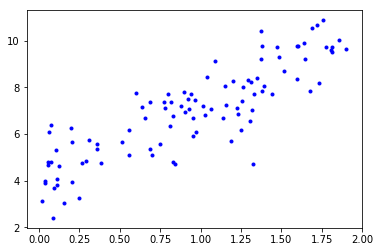

In [3]:
# plot random data
plt.plot(X, y, 'b.')
plt.show()

## The Normal Equation

In [4]:
# Calculate theta by normal equation
X_b = np.c_[np.ones((100, 1)), X] # add x0 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.11425508],
       [3.04615343]])

In [5]:
# make prediction
X_new = np.array([[0], [2]])            # X轴最左边和最右边的值
X_new_b = np.c_[np.ones((2, 1)), X_new] # 为了预测添加Theta0
y_predict = X_new_b.dot(theta_best)     # 2x2 * 2x1
y_predict

array([[ 4.11425508],
       [10.20656194]])

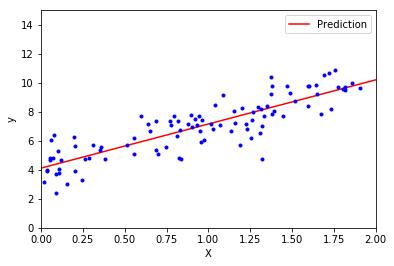

In [6]:
# plot prediction
plt.plot(X_new, y_predict, 'r-', label='Prediction')
plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 15])
plt.xlabel('X')
plt.ylabel('y')
# plt.show()
plt.legend() # 为了显示图例label使用

In [7]:
# Using LinearRegression in sklearn
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.predict(X_new)

/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


array([[ 4.11425508],
       [10.20656194]])

#### Note: Computational Complexity

The computational complexity of inverting such a matrix is typically about O(n2.4) to O(n3) (depending on the implementation). 

The Normal Equation gets very slow when the number of features grows large (e.g., 100,000).

## Batch Gradient Descent

In [8]:
eta = 0.1 # learning rate
n_iterations = 1000

theta = np.random.randn(2, 1) # random initialization
bgd_hypothesis = []
for iteration in range(n_iterations):
    # 计算Gradient，这里每次会对所有X数据进行处理，因此在训练数据很多的情况下，
    # 效率比较差(Batch Gradient Descent)，但可以同时进行很多feature的计算，这点上比Normal Equation要好
    gradients = 2 / m * X_b.T.dot(X_b.dot(theta) - y) 
    theta = theta - eta * gradients
    # 采集递减过程的数据，用于展示图形
    std_error = sum(2 / m * np.sqrt(np.power(X_b.dot(theta) - y, 2)))
    bgd_hypothesis.append(std_error)
print("theta:\n", theta)
print("predict:\n", X_new_b.dot(theta))

theta:
 [[4.11425508]
 [3.04615343]]
predict:
 [[ 4.11425508]
 [10.20656194]]


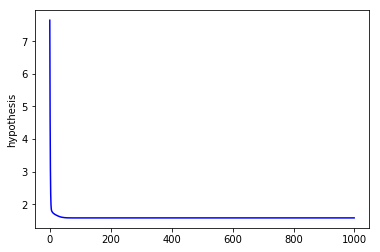

In [9]:
# 这里的学习曲线下降非常快导致看起来像一条直线...
plt.plot(range(n_iterations), bgd_hypothesis, 'b-')
plt.ylabel("hypothesis")
plt.show()

## Stochastic Gradient Descent

Stochastic Gradient Descent just picks a random instance in the training set at every step and computes the gradients based only on that single instance.

In [10]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparamaters

def learning_schedule(t): # learning rate 逐步递减, 基数为 5/50
    return t0 / (t + t1)

theta = np.random.randn(2, 1) # random initialization

sgd_hypothesis = []
for epoch in range(n_epochs):
    # 采集递减过程的数据，用于展示图形
    std_error = sum(2 / m * np.sqrt(np.power(X_b.dot(theta) - y, 2)))
    sgd_hypothesis.append(std_error)
    
    # 每轮遍历会逐步扩大随机取值范围直到所有训练数据
    for i in range(m):
        # 随机取一组相邻数值计算Gradient
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

print("theta:\n", theta)
print("predict:\n", X_new_b.dot(theta))

theta:
 [[4.15818359]
 [3.0438351 ]]
predict:
 [[ 4.15818359]
 [10.2458538 ]]


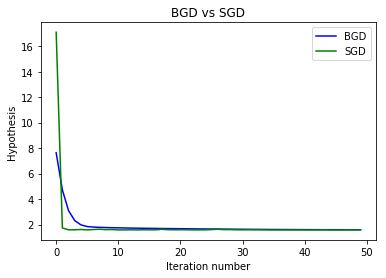

In [11]:
plt.plot(range(n_epochs), bgd_hypothesis[:n_epochs], 'b-', label='BGD')
plt.plot(range(n_epochs), sgd_hypothesis, 'g-', label='SGD')
plt.title('BGD vs SGD')
plt.ylabel('Hypothesis')
plt.xlabel('Iteration number')
plt.legend()

### BGD & SGD 在相近效果下的对比
Batch Gradient Descent 遍历1000遍，每轮遍历需要计算所有100个训练数据

Stochastic Gradient Descent 只需遍历50遍，每轮遍历所随机取100个训练数据

In [12]:
# Using SGD in sklearn
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=50, penalty=None, eta0=0.1)
sgd_reg.fit(X_b, y.ravel()) # y.ravel()降维作用
sgd_reg.predict(X_new_b)

array([ 4.01492509, 10.00769259])

## Mini-batch Gradient Descent

Mini-batch Gradient Descent结合了BGD和SGD的特性，每轮遍历随机选取一小组数据进行Gradient计算

我们可以通过矩阵来进行多个数据的计算，这种矩阵计算可以利用硬件进行加速

In [13]:
mini_batch_size = 10

theta = np.random.randn(2, 1) # random initialization
mgd_hypothesis = []

for epoch in range(n_epochs):
    # 采集递减过程的数据，用于展示图形
    std_error = sum(2 / m * np.sqrt(np.power(X_b.dot(theta) - y, 2)))
    mgd_hypothesis.append(std_error)
    
    # 每轮遍历会逐步扩大随机取值范围直到所有训练数据
    for i in range(m):
        # 随机取一组相邻数值计算Gradient
        batch_count = min(max(i, 2), mini_batch_size)
        random_indices = np.random.permutation(m)[:batch_count]
        Xi = X_b[random_indices]
        yi = y[random_indices]
        gradients = 2 / batch_count * Xi.T.dot(Xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
    
print("theta:\n", theta)
print("predict:\n", X_new_b.dot(theta))

theta:
 [[4.10347506]
 [3.04152514]]
predict:
 [[ 4.10347506]
 [10.18652533]]


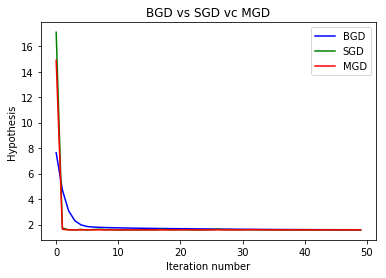

In [14]:
plt.plot(range(n_epochs), bgd_hypothesis[:n_epochs], 'b-', label='BGD')
plt.plot(range(n_epochs), sgd_hypothesis, 'g-', label='SGD')
plt.plot(range(n_epochs), mgd_hypothesis, 'r-', label='MGD')
plt.title('BGD vs SGD vc MGD')
plt.ylabel('Hypothesis')
plt.xlabel('Iteration number')
plt.legend()

Mini-batch的递减曲线与SGD相近，但会比SGD更快接近最优值，同时最后的波动会比SGD小

## Polynomial Regression

In [15]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

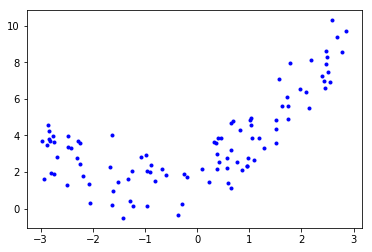

In [16]:
plt.plot(X, y, 'b.')
plt.show()

In [17]:
# 多项式特征集转换，生成更多的feature值
# 比如：一个输入样本是２维的。形式如[a,b] ,则二阶多项式的特征集如下[1,a,b,a^2,ab,b^2]
from sklearn.preprocessing import PolynomialFeatures
ploy_features = PolynomialFeatures(degree=2, include_bias=False)
X_ploy = ploy_features.fit_transform(X)
print("X_ploy[0]:", X_ploy[0], "X[0]:", X[0])

X_ploy[0]: [0.64253009 0.41284491] X[0]: [0.64253009]


In [18]:
lin_reg = LinearRegression()
lin_reg.fit(X_ploy, y)
print(lin_reg.intercept_, lin_reg.coef_)

[2.03245543] [[1.07029823 0.5402848 ]]


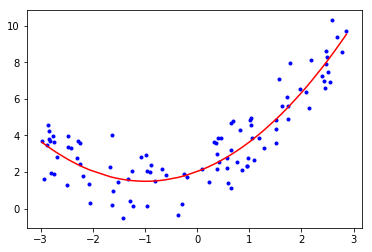

In [19]:
# 显示预测图像
def plot_prediction_line(X, y, y_pred):
    X_sorted = []
    y_sorted = []
    for x_value, y_value in sorted(zip(X, y_pred)):
        X_sorted.append(x_value)
        y_sorted.append(y_value)
    plt.plot(X, y, 'b.')
    plt.plot(X_sorted, y_sorted, 'r-')
    plt.show()
plot_prediction_line(X, y, lin_reg.predict(X_ploy).flatten())

## Learning Curve

用于决定模型是overfitting还是underfitting

In [20]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=2, label="val")
    plt.ylim(0, 3)
    plt.legend()

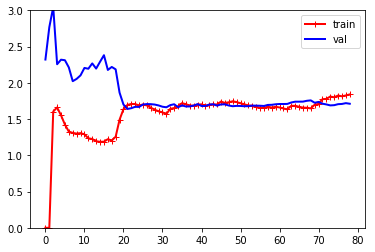

In [21]:
# Underfitting Demo
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

Underfitting，理想误差值在两线下面，这种情况下增加样本数对提高性能并无帮助

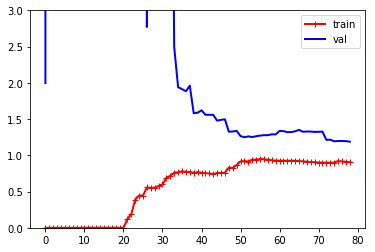

In [22]:
# Overfitting Demo
from sklearn.pipeline import Pipeline
polynomial_regression = Pipeline([
    ('PolynomialFeatures', PolynomialFeatures(degree=20, include_bias=False)),
    ('LinearRegression', LinearRegression()),
])
plot_learning_curves(polynomial_regression, X, y)

Overfitting，理想误差值在两线中间，这种情况下增加样本数可以提高算法性能

## Regularized Linear Models

### Ridge Regression

这个算法就是Coursera课程里面的Regularization解法

In [23]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=0, solver='cholesky')
ridge_reg.fit(X_ploy, y)

Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='cholesky', tol=0.001)

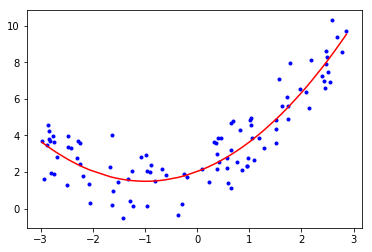

In [24]:
# 显示预测图像
plot_prediction_line(X, y, ridge_reg.predict(X_ploy).flatten())

- alpha值越大，预测曲线越平滑
- 当alpha=0时，算法等于LinearRegression
- 当alphe值超级大是，预测曲线趋近直线

In [25]:
# SGDRegression with regularization
sgd_reg = SGDRegressor(penalty='l2', alpha=1)
sgd_reg.fit(X_ploy, y.ravel())

SGDRegressor(alpha=1, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

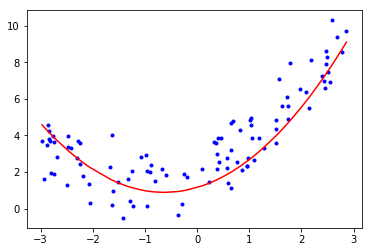

In [26]:
# 显示预测图像
plot_prediction_line(X, y, sgd_reg.predict(X_ploy).flatten())

## Lasso Regression
Lasso Regression automatically performs feature selection and outputs a sparse model 

- l1正则化过程会使所有theta参数趋近于0，alpha就是趋近于0的速度，当alpha=1时，所有theta值会变成0
    对于一些不太重要的参数，会更快趋近0，因此这个算法会更加突出强关联的特性参数(theta)


- l2正则化过程则是一个相对平滑的过程，参数之间会互相作用，比较平均地趋向0。alpha值越大，theta值越小。
    因此这个算法主要是为了减少过度匹配

In [27]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_ploy, y)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

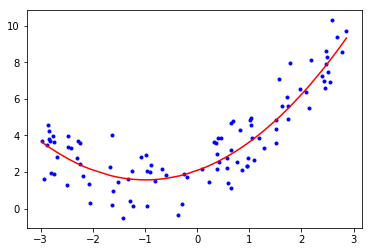

In [28]:
# 显示预测图像
plot_prediction_line(X, y, lasso_reg.predict(X_ploy).flatten())

## Elastic Net

Elastic Net是Ridge Regression和Lasso Regression的综合，通过一个r参数来权衡算法侧重

当r = 1时，算法等于Lasso Regression

当r = 0时，算法等于Ridge Regression

Ridge(0) ----- r ----- Lasso(1)

In [29]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=1)
elastic_net.fit(X_ploy, y)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=1,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

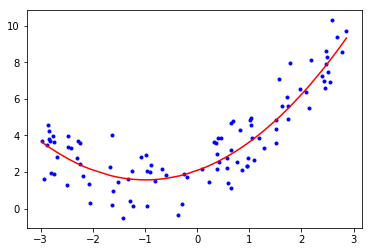

In [30]:
# 显示预测图像
plot_prediction_line(X, y, elastic_net.predict(X_ploy).flatten())

### 关于模型的选择：

总的来说，选择带有一点Regulazation的正则化模型是比较靠谱的，不太建议选择普通LinearRegression。

可以先尝试RidgeRegression。如果需要突出强关联的特性，可以使用ElasticNet。

LassoRegression的效果会比较激进，一般不太推荐

## Early Stopping

某些情况下，随着模型训练次数逐步增多，Validation的偏差在达到最低点之后，可能会反弹，

这种情况下提前结束训练是个比较好的选择

# Part2: Logistic Regression

In [31]:
from sklearn import datasets
iris = datasets.load_iris()
print(list(iris.keys()))
print('target_names', iris['target_names'])
print('feature_names', iris['feature_names'])
print(iris['DESCR'])

['data', 'target', 'target_names', 'DESCR', 'feature_names']
target_names ['setosa' 'versicolor' 'virginica']
feature_names ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   

In [32]:
X = iris['data'][:, 3:] # patal width
y = (iris['target'] == 2).astype(np.int) # 1 if Iris-virginica, else 0

In [33]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

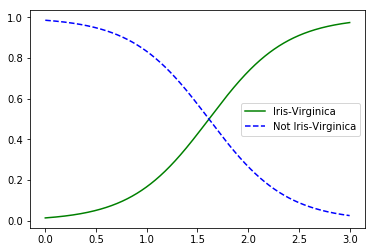

In [34]:
# plot graphic
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new) # 返回预测可能性，y值包括积极概率和消极概率，相加为1
plt.plot(X_new, y_proba[:, 1], 'g-', label='Iris-Virginica')
plt.plot(X_new, y_proba[:, 0], 'b--', label="Not Iris-Virginica")
plt.legend()

In [35]:
# 分界线在1.6左右，这里测试一下predict的逻辑，是以50%可能性作为分界线
log_reg.predict([[1.7], [1.5]])

array([1, 0])

In [36]:
X = iris['data'][:, 2:] # patal width + patel length
y = (iris['target'] == 2).astype(np.int) # 1 if Iris-virginica, else 0

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

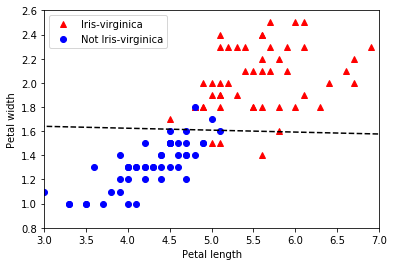

In [37]:
# Plot graphic
virginica_items = []
non_virginica_items = []
for i in range(len(X)):
    if y[i] == 1:
        virginica_items.append(list(X[i]))
    else:
        non_virginica_items.append(list(X[i]))
virginica_items = np.array(virginica_items)
non_virginica_items = np.array(non_virginica_items)
theta0 = log_reg.intercept_
theta1 = log_reg.coef_[0][0]
theta2 = log_reg.coef_[0][1]
plt.plot(virginica_items[:,0], virginica_items[:,1], '^r', label='Iris-virginica')
plt.plot(non_virginica_items[:, 0], non_virginica_items[:, 1], 'ob', label='Not Iris-virginica')
plt.plot([0, -theta0 / theta1], [-theta0 / theta2, 0], 'k--')
plt.xlim(3.0, 7.0)
plt.ylim(0.8, 2.6)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.legend()

## Softmax Regresssion

Softmax Regression也称为Multinomial Logistic Regression，可进行多个分类的判断。

不同于之前提过的多个binary classifier组合进行多分类判断，Softmax可通过单次计算直接输出结果。

原理在于我们把之前logistic hypothesis公式中的vector替换为matrix，然后对这个matrix进行训练拟合

**注意：**Softmax Regression每次只能输出一个分类，不适用那种需要一次性输出多个分类的场景

In [38]:
X = iris['data'][:, (2, 3)] # patal length, patal width 
y = iris['target']
softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [39]:
softmax_reg.coef_

array([[-4.58536208, -2.24803476],
       [ 0.16014121, -2.15447875],
       [ 4.42522087,  4.40251352]])

In [40]:
softmax_reg.intercept_

array([ 18.87940407,   6.38186888, -25.26127294])

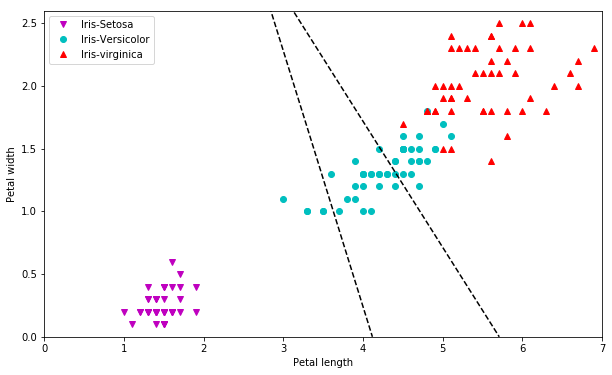

In [41]:
# Plot graphic
setosa_itema = []
versicolor_items = []
virginica_items = []

for i in range(len(X)):
    if y[i] == 0:
        setosa_itema.append(list(X[i]))
    elif y[i] == 1:
        versicolor_items.append(list(X[i]))
    else:
        virginica_items.append(list(X[i]))
setosa_itema = np.array(setosa_itema)
versicolor_items = np.array(versicolor_items)
virginica_items = np.array(virginica_items)
theta0 = softmax_reg.intercept_
theta1 = softmax_reg.coef_[:, 0]
theta2 = softmax_reg.coef_[:, 1]
plt.figure(figsize=(10,6))
plt.plot(setosa_itema[:,0], setosa_itema[:,1], 'vm', label='Iris-Setosa')
plt.plot(versicolor_items[:,0], versicolor_items[:,1], 'oc', label='Iris-Versicolor')
plt.plot(virginica_items[:, 0], virginica_items[:, 1], '^r', label='Iris-virginica')
plt.plot([0, -theta0[0] / theta1[0]], [-theta0[0] / theta2[0], 0], 'k--')
plt.plot([0, -theta0[1] / theta1[1]], [-theta0[1] / theta2[1], 0], 'k--')
plt.plot([0, -theta0[2] / theta1[2]], [-theta0[2] / theta2[2], 0], 'k--')
plt.xlim(0.0, 7.0)
plt.ylim(0.0, 2.6)
plt.xlabel('Petal length')
plt.ylabel('Petal width')

plt.legend()